In [ ]:
!pip install sqlalchemy==1.4.46
!pip install pandasql
!pip install geopy
!pip install -U kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.2 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.36
    Uninstalling SQLAlchemy-2.0.36:
      Successfully uninstalled SQLAlchemy-2.0.36
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.46 which is incompatible.
  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26772 sha256=2eb65ac90b1d430f786e190efc71e5d26b194319422f5ce3caed1d4280854087
  Stored in directory: /root/.cache/pip/wheels/e9/bc/3a/8434bdcccf5779e72894a9b24fecbdcaf97940607eaf4bcdf9
Successfully built pandasql
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.7 MB/s eta 0:00:00


In [ ]:
pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 1.7 MB/s eta 0:00:00


In [ ]:
pip install shap


In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import plotly.express as px
import seaborn as sns
import pandasql as ps #SQL on Pandas Dataframe
import matplotlib.pyplot as plt
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.decomposition import LatentDirichletAllocation
from pyspark.sql import SparkSession
from pyspark.sql.functions import length, udf, col
from pyspark.sql.types import DoubleType, StringType
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import shap
import pyspark.sql.functions as F
from wordcloud import WordCloud
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import math
from getpass import getpass
import re
import ast
import json
import os
from collections import Counter
import random

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d jiashenliu/515k-hotel-reviews-data-in-europe
!unzip 515k-hotel-reviews-data-in-europe.zip

Mounted at /content/drive
Dataset URL: https://www.kaggle.com/datasets/jiashenliu/515k-hotel-reviews-data-in-europe
License(s): CC0-1.0
 91% 41.0M/45.1M [00:00<00:00, 104MB/s]
100% 45.1M/45.1M [00:00<00:00, 110MB/s]
Archive:  515k-hotel-reviews-data-in-europe.zip
  inflating: Hotel_Reviews.csv       


In [ ]:
# Initialize PySpark

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("HotelReviews").getOrCreate()

In [ ]:
# Read the dataset into a PySpark DataFrame

df = spark.read.csv('Hotel_Reviews.csv', header=True, inferSchema=True)

# Show the first few rows of the DataFrame

df.show(5)

+--------------------+----------------------------+-----------+-------------+-----------+--------------------+--------------------+---------------------------------+-----------------------+--------------------+---------------------------------+------------------------------------------+--------------+--------------------+-----------------+----------+---------+
|       Hotel_Address|Additional_Number_of_Scoring|Review_Date|Average_Score| Hotel_Name|Reviewer_Nationality|     Negative_Review|Review_Total_Negative_Word_Counts|Total_Number_of_Reviews|     Positive_Review|Review_Total_Positive_Word_Counts|Total_Number_of_Reviews_Reviewer_Has_Given|Reviewer_Score|                Tags|days_since_review|       lat|      lng|
+--------------------+----------------------------+-----------+-------------+-----------+--------------------+--------------------+---------------------------------+-----------------------+--------------------+---------------------------------+------------------------------

In [ ]:
# Check for null values in each column

from pyspark.sql.functions import col, sum as _sum

# Count nulls in each column

null_counts = df.select([_sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])

null_counts.show()

+-------------+----------------------------+-----------+-------------+----------+--------------------+---------------+---------------------------------+-----------------------+---------------+---------------------------------+------------------------------------------+--------------+----+-----------------+---+---+
|Hotel_Address|Additional_Number_of_Scoring|Review_Date|Average_Score|Hotel_Name|Reviewer_Nationality|Negative_Review|Review_Total_Negative_Word_Counts|Total_Number_of_Reviews|Positive_Review|Review_Total_Positive_Word_Counts|Total_Number_of_Reviews_Reviewer_Has_Given|Reviewer_Score|Tags|days_since_review|lat|lng|
+-------------+----------------------------+-----------+-------------+----------+--------------------+---------------+---------------------------------+-----------------------+---------------+---------------------------------+------------------------------------------+--------------+----+-----------------+---+---+
|            0|                           0|        

In [ ]:
from pyspark.sql.functions import regexp_replace, udf, col

from pyspark.sql.types import IntegerType

# Remove numbers from the 'Hotel_Address' column

df = df.withColumn('Hotel_Address', regexp_replace(col('Hotel_Address'), r'\d+', ''))

# Create a UDF to extract the integer value from the 'days_since_review' column

def extract_days(value):

    return int(value.split()[0]) if value else None

extract_days_udf = udf(extract_days, IntegerType())

# Apply the UDF to create the 'days_since_review' column

df = df.withColumn('days_since_review', extract_days_udf(col('days_since_review')))

# Select and display the 'Tags' and 'days_since_review' columns

df.select('Tags', 'days_since_review').show(5, truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------+-----------------+
|Tags                                                                                                                               |days_since_review|
+-----------------------------------------------------------------------------------------------------------------------------------+-----------------+
|[' Leisure trip ', ' Couple ', ' Duplex Double Room ', ' Stayed 6 nights ']                                                        |0                |
|[' Leisure trip ', ' Couple ', ' Duplex Double Room ', ' Stayed 4 nights ']                                                        |0                |
|[' Leisure trip ', ' Family with young children ', ' Duplex Double Room ', ' Stayed 3 nights ', ' Submitted from a mobile device ']|3                |
|[' Leisure trip ', ' Solo traveler ', ' Duplex Double Room ', ' Stayed 3 nights ']     

In [ ]:
# Set legacy time parser policy to handle date parsing errors

spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

from pyspark.sql.functions import to_date, year, month, dayofmonth, dayofweek

# Convert 'Review_Date' to a PySpark DateType column

df = df.withColumn('Review_Date', to_date(col('Review_Date'), 'MM/dd/yyyy'))

# Extract year, month, day, and day of the week from 'Review_Date'

df = df.withColumn('Review_Year', year(col('Review_Date')))

df = df.withColumn('Review_Month', month(col('Review_Date')))

df = df.withColumn('Review_Day', dayofmonth(col('Review_Date')))

df = df.withColumn('Review_DayOfWeek', dayofweek(col('Review_Date')))

# Show the first few rows

df.show(5)


+--------------------+----------------------------+-----------+-------------+-----------+--------------------+--------------------+---------------------------------+-----------------------+--------------------+---------------------------------+------------------------------------------+--------------+--------------------+-----------------+----------+---------+-----------+------------+----------+----------------+
|       Hotel_Address|Additional_Number_of_Scoring|Review_Date|Average_Score| Hotel_Name|Reviewer_Nationality|     Negative_Review|Review_Total_Negative_Word_Counts|Total_Number_of_Reviews|     Positive_Review|Review_Total_Positive_Word_Counts|Total_Number_of_Reviews_Reviewer_Has_Given|Reviewer_Score|                Tags|days_since_review|       lat|      lng|Review_Year|Review_Month|Review_Day|Review_DayOfWeek|
+--------------------+----------------------------+-----------+-------------+-----------+--------------------+--------------------+---------------------------------+---

In [ ]:
from pyspark.sql.functions import col, count, when

def find_outliers_pyspark(df):

    # Dictionary to store outlier counts for each column

    outlier_counts = {}

    for column in df.columns:

        # Check if the column is numeric

        if dict(df.dtypes)[column] in ['int', 'double']:

            # Calculate Q1, Q3, and IQR

            q1, q3 = df.approxQuantile(column, [0.25, 0.75], 0)

            iqr = q3 - q1

            lower_bound = q1 - 3 * iqr

            upper_bound = q3 + 3 * iqr

            # Create a mask for outliers

            outliers = df.filter((col(column) < lower_bound) | (col(column) > upper_bound))

            # Count the outliers

            outlier_counts[column] = outliers.count()

    return outlier_counts

# Find outliers in the DataFrame

outliers = find_outliers_pyspark(df)

# Display outliers for each column

for column, count in outliers.items():

    print(f"Outliers in {column}: {count}")

# Display the total number of rows in the DataFrame

print(f"Total rows: {df.count()}")


Outliers in Additional_Number_of_Scoring: 13214
Outliers in Average_Score: 65
Outliers in Review_Total_Negative_Word_Counts: 16095
Outliers in Total_Number_of_Reviews: 6046
Outliers in Review_Total_Positive_Word_Counts: 13164
Outliers in Total_Number_of_Reviews_Reviewer_Has_Given: 20667
Outliers in Reviewer_Score: 0
Outliers in days_since_review: 0
Outliers in Review_Year: 0
Outliers in Review_Month: 0
Outliers in Review_Day: 0
Outliers in Review_DayOfWeek: 0
Total rows: 515738


In [ ]:
from pyspark.sql.functions import col, count, lit

def clean_outliers_pyspark(df):

    # Start with the original DataFrame

    cleaned_df = df

    total_rows = df.count()

    total_outliers = 0

    for column in df.columns:

        # Check if the column is numeric

        if dict(df.dtypes)[column] in ['int', 'double']:

            # Calculate Q1, Q3, and IQR

            q1, q3 = df.approxQuantile(column, [0.25, 0.75], 0)

            iqr = q3 - q1

            lower_bound = q1 - 3 * iqr

            upper_bound = q3 + 3 * iqr

            # Identify and count outliers

            outliers_df = cleaned_df.filter((col(column) < lower_bound) | (col(column) > upper_bound))

            num_outliers = outliers_df.count()

            total_outliers += num_outliers

            # Remove outliers

            cleaned_df = cleaned_df.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))

    # Calculate the percentage of rows that were outliers

    outlier_percentage = (total_outliers / total_rows) * 100

    print(f"Total outliers: {total_outliers}")

    print(f"Percentage of outliers: {outlier_percentage:.2f}%")

    # Return the cleaned DataFrame

    return cleaned_df

# Apply the cleaning function

df_cleaned = clean_outliers_pyspark(df)

# Display the size of the cleaned DataFrame

print(f"Size of cleaned DataFrame: {df_cleaned.count()}")

# Show the first few rows of the cleaned DataFrame

df_cleaned.show(5)


Total outliers: 61287
Percentage of outliers: 11.88%
Size of cleaned DataFrame: 454451
+--------------------+----------------------------+-----------+-------------+-----------+--------------------+--------------------+---------------------------------+-----------------------+--------------------+---------------------------------+------------------------------------------+--------------+--------------------+-----------------+----------+---------+-----------+------------+----------+----------------+
|       Hotel_Address|Additional_Number_of_Scoring|Review_Date|Average_Score| Hotel_Name|Reviewer_Nationality|     Negative_Review|Review_Total_Negative_Word_Counts|Total_Number_of_Reviews|     Positive_Review|Review_Total_Positive_Word_Counts|Total_Number_of_Reviews_Reviewer_Has_Given|Reviewer_Score|                Tags|days_since_review|       lat|      lng|Review_Year|Review_Month|Review_Day|Review_DayOfWeek|
+--------------------+----------------------------+-----------+-------------+----

In [ ]:
# Spark SQL:

df.createOrReplaceTempView("reviews_table")

# Write the SQL query
query = """
SELECT Reviewer_Score, COUNT(*) as count
FROM reviews_table
GROUP BY Reviewer_Score
ORDER BY count DESC
LIMIT 10
"""

# Execute the query
review_count = spark.sql(query)

# Show the results
review_count.show()

+--------------+------+
|Reviewer_Score| count|
+--------------+------+
|          10.0|115853|
|           9.6| 71167|
|           9.2| 58583|
|           8.8| 46429|
|           8.3| 41128|
|           7.5| 34878|
|           7.9| 33097|
|           7.1| 24855|
|           6.7| 18793|
|           6.3| 14924|
+--------------+------+



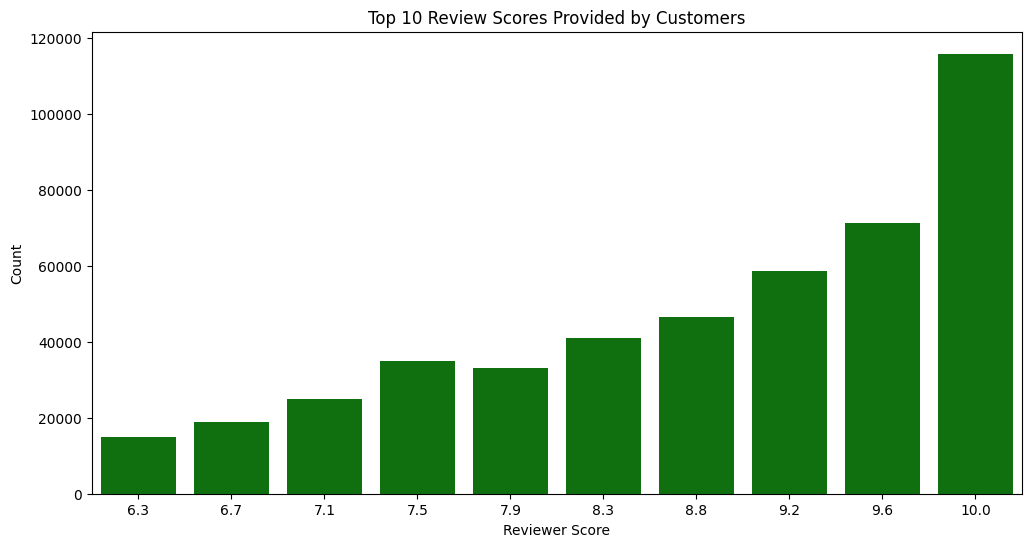

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the Spark DataFrame to a Pandas DataFrame
review_count_pd = review_count.toPandas()

# Create the barplot
plt.figure(figsize=(12, 6))
sns.barplot(x='Reviewer_Score', y='count', data=review_count_pd, color='green')
plt.title('Top 10 Review Scores Provided by Customers')
plt.xlabel('Reviewer Score')
plt.ylabel('Count')
plt.show()

In [ ]:
df.createOrReplaceTempView("reviews_table")

# Write the SQL query
query = """
SELECT Hotel_Name, AVG(Reviewer_Score) as Average_Score
FROM reviews_table
GROUP BY Hotel_Name
ORDER BY Average_Score DESC
LIMIT 10
"""

# Execute the query
top_hotels = spark.sql(query)

# Show the results
top_hotels.show()

+--------------------+-----------------+
|          Hotel_Name|    Average_Score|
+--------------------+-----------------+
|          Ritz Paris|            9.725|
|   Hotel Casa Camper|  9.7189368770764|
|                  41|9.711650485436897|
|H tel de La Tamis...|9.688524590163938|
|Le Narcisse Blanc...|9.671929824561403|
|H10 Casa Mimosa 4...|9.660344827586211|
| Hotel Eiffel Blomet|9.646666666666668|
|    Hotel The Serras|9.623474178403743|
|45 Park Lane Dorc...|9.603571428571428|
|      The Soho Hotel| 9.59745222929936|
+--------------------+-----------------+



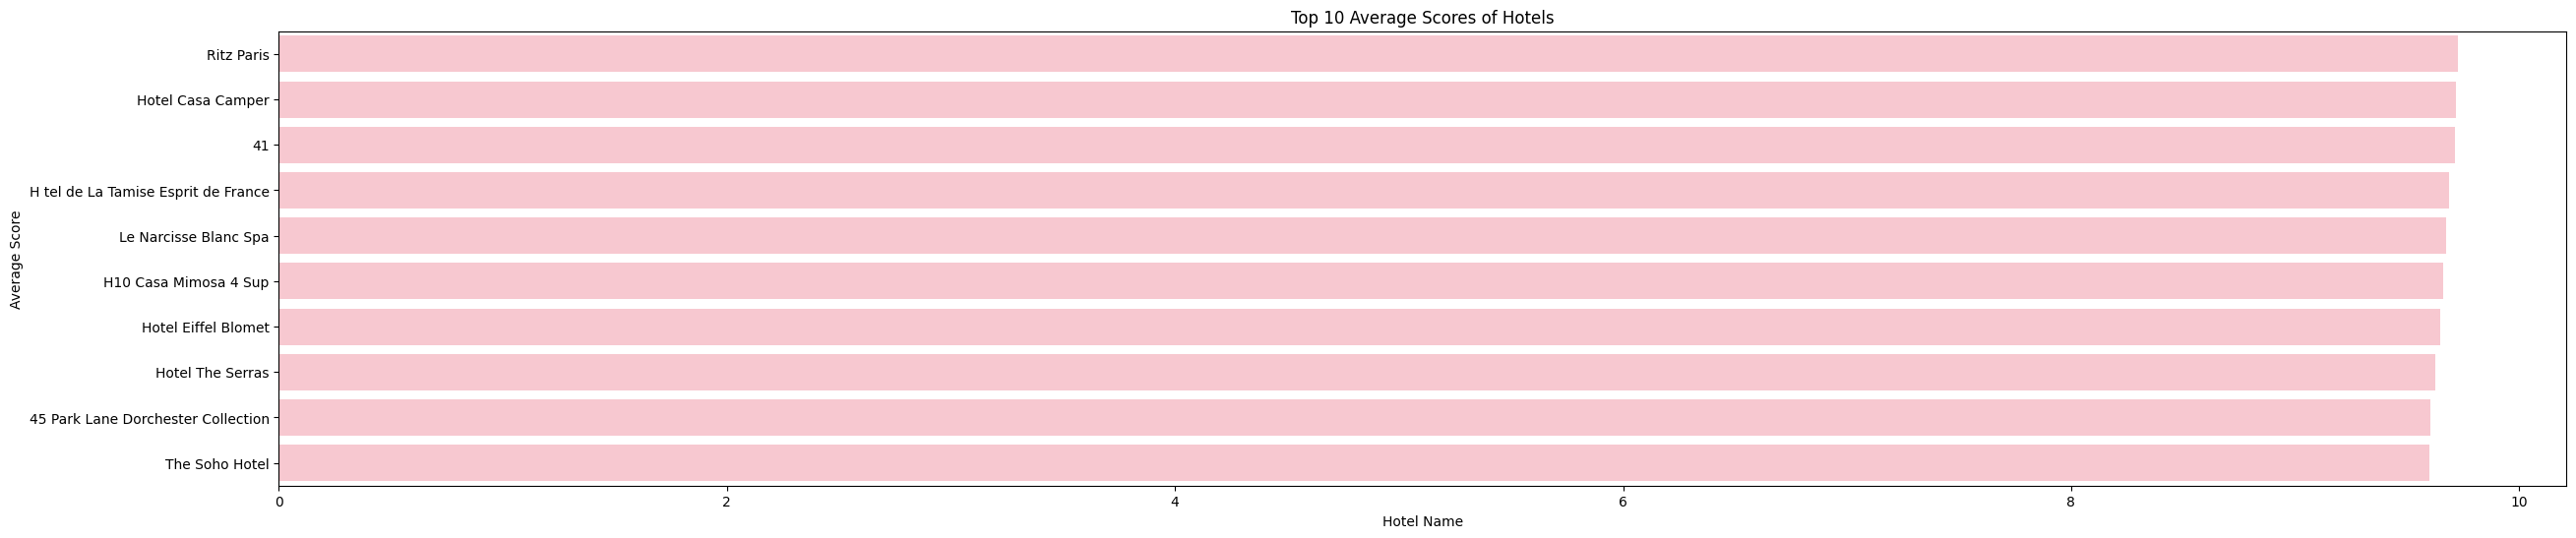

In [ ]:
top_hotels_pd = top_hotels.toPandas()

# Create the barplot

plt.figure(figsize=(30, 6))
sns.barplot(x='Average_Score', y='Hotel_Name', data=top_hotels_pd, color = 'pink')
plt.title('Top 10 Average Scores of Hotels')
plt.xlabel('Hotel Name')
plt.ylabel('Average Score')
plt.show()

In [ ]:
# Register the DataFrame as a temporary SQL table
df.createOrReplaceTempView("reviews_table")

# Write the SQL query
query = """
SELECT Hotel_Name, AVG(Reviewer_Score) as Average_Score
FROM reviews_table
GROUP BY Hotel_Name
ORDER BY Average_Score ASC
LIMIT 10
"""

# Execute the query
bottom_hotels = spark.sql(query)

# Show the results
bottom_hotels.show()


+--------------------+------------------+
|          Hotel_Name|     Average_Score|
+--------------------+------------------+
|       Hotel Liberty| 5.121538461538464|
|  Kube Hotel Ice Bar| 5.852631578947369|
|       Villa Eugenie| 5.864516129032259|
|Savoy Hotel Amste...| 6.009465020576125|
|Holiday Inn Paris...|6.3297297297297295|
|Best Western Mait...| 6.374999999999998|
|Ibis Styles Milan...| 6.383333333333334|
|Villa Lut ce Port...| 6.385106382978724|
|     Hotel Cavendish|6.4420652173913195|
|   The Tophams Hotel|6.4799999999999995|
+--------------------+------------------+



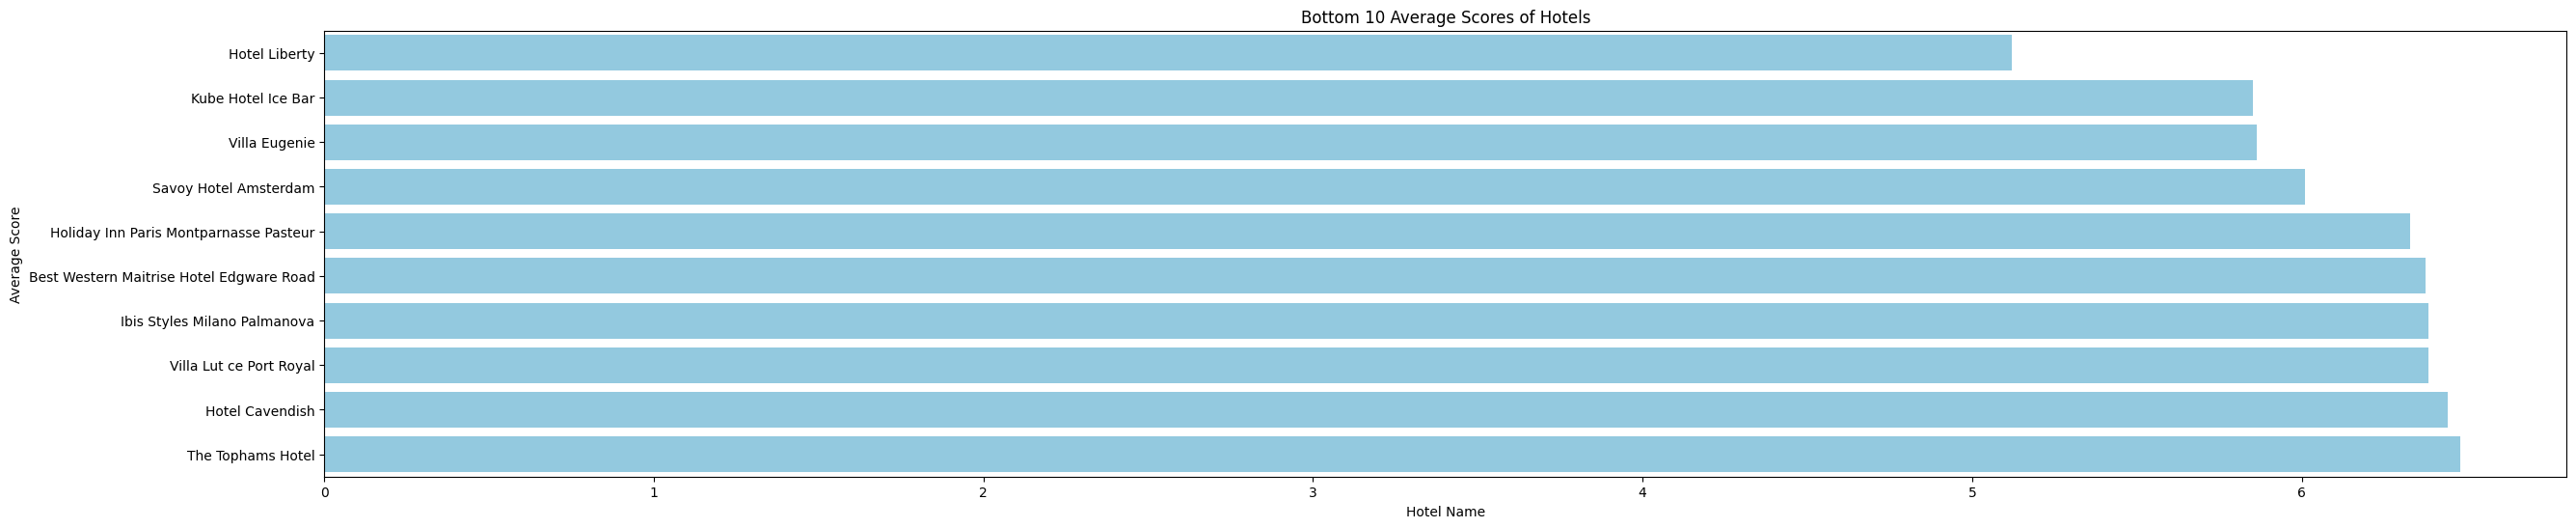

In [ ]:
# Data visualization
bottom_hotels_pd = bottom_hotels.toPandas()

# Create the barplot:
plt.figure(figsize=(30, 6))
sns.barplot(x='Average_Score', y='Hotel_Name', data=bottom_hotels_pd, color = 'skyblue')
plt.title('Bottom 10 Average Scores of Hotels')
plt.xlabel('Hotel Name')
plt.ylabel('Average Score')
plt.show()

In [ ]:
# Register the DataFrame as a temporary SQL table
df.createOrReplaceTempView("reviews_table")

# Write the SQL query
query = """
SELECT Review_Month,
       AVG(Reviewer_Score) as Average_Score,
       COUNT(*) as review_count
FROM reviews_table
GROUP BY Review_Month
ORDER BY Review_Month
"""

# Execute the query
month_scores = spark.sql(query)

# Show the results
month_scores.show()


+------------+-----------------+------------+
|Review_Month|    Average_Score|review_count|
+------------+-----------------+------------+
|           1|8.485011031766991|       42151|
|           2| 8.52805837894219|       38370|
|           3|8.479832157626122|       41110|
|           4|  8.4315299769142|       42883|
|           5| 8.38104108410431|       46490|
|           6|8.391418780306104|       42896|
|           7|8.335486029441745|       49318|
|           8| 8.41173823808038|       50672|
|           9|8.290647685490946|       42428|
|          10| 8.26157653445267|       43843|
|          11|8.338843480678655|       35970|
|          12|8.427131567652415|       39607|
+------------+-----------------+------------+



(8.0, 9.0)

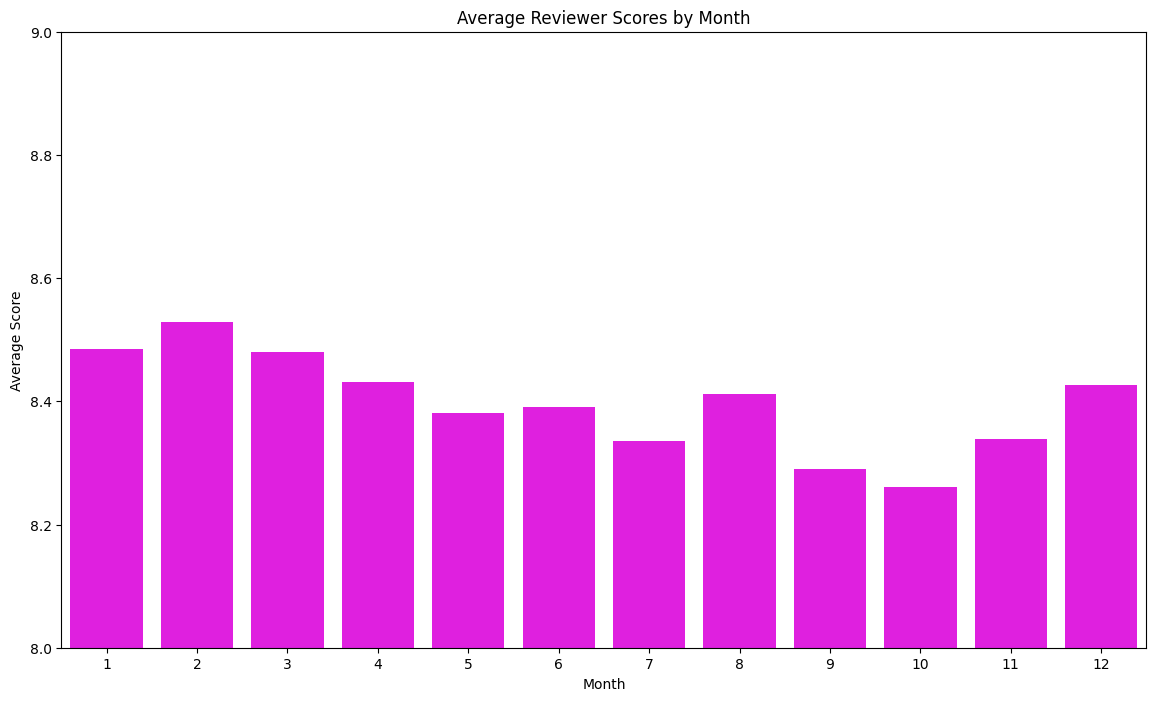

In [ ]:
month_scores_pd = month_scores.toPandas()

# Create the barplot
plt.figure(figsize=(14, 8))

# Create bar plot for Average_Score
sns.barplot(x='Review_Month', y='Average_Score', data=month_scores_pd, color = 'magenta')
plt.title('Average Reviewer Scores by Month')
plt.xlabel('Month')
plt.ylabel('Average Score')
plt.ylim(8, 9)

In [ ]:
# Register the DataFrame as a temporary SQL table
df.createOrReplaceTempView("reviews_table")

# Write the SQL query
query_review_count = """
SELECT Hotel_Name,
       COUNT(*) as Review_Count
FROM reviews_table
GROUP BY Hotel_Name
ORDER BY Review_Count DESC
LIMIT 20
"""

# Execute the query
hotel_reviews = spark.sql(query_review_count)

# Show the results
hotel_reviews.show()


+--------------------+------------+
|          Hotel_Name|Review_Count|
+--------------------+------------+
|Britannia Interna...|        4789|
| Strand Palace Hotel|        4256|
|Park Plaza Westmi...|        4169|
|Copthorne Tara Ho...|        3578|
|DoubleTree by Hil...|        3212|
|Grand Royale Lond...|        2958|
|Holiday Inn Londo...|        2768|
|Hilton London Met...|        2628|
|Millennium Glouce...|        2565|
|Intercontinental ...|        2551|
|Park Grand Paddin...|        2288|
|Hilton London Wem...|        2227|
|Park Plaza County...|        2223|
| Blakemore Hyde Park|        2178|
|Park Plaza London...|        2167|
|M by Montcalm Sho...|        2155|
|DoubleTree by Hil...|        2147|
|St James Court A ...|        2070|
|Park Grand London...|        2059|
|      Hotel Da Vinci|        1877|
+--------------------+------------+



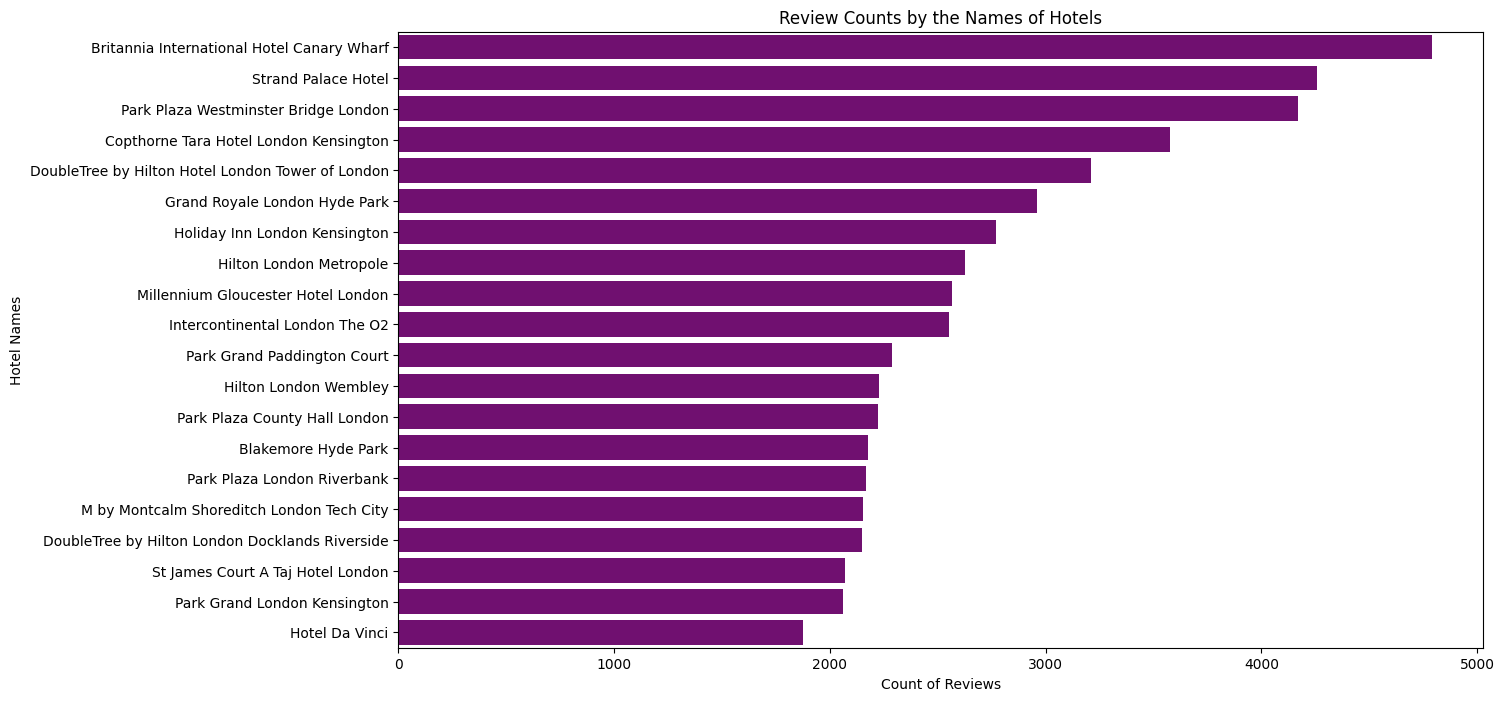

In [ ]:
hotel_reviews_pd = hotel_reviews.toPandas()
plt.figure(figsize=(14, 8))
sns.barplot(x='Review_Count', y='Hotel_Name', data=hotel_reviews_pd, color = 'purple')
plt.title('Review Counts by the Names of Hotels')
plt.xlabel('Count of Reviews')
plt.ylabel('Hotel Names')

# Show the bar plot
plt.show()

In [ ]:
# Register the DataFrame as a temporary SQL table
df.createOrReplaceTempView("reviews_table")

# Write the SQL query
query = """
SELECT Tags,
       AVG(Reviewer_Score) as Average_Score
FROM reviews_table
WHERE Tags LIKE '%Stayed%'
GROUP BY Tags
ORDER BY Average_Score DESC
"""

# Execute the query
tags_scores = spark.sql(query)

# Show the results
tags_scores.show()


+--------------------+-------------+
|                Tags|Average_Score|
+--------------------+-------------+
|[' Business trip ...|         10.0|
|[' Leisure trip '...|         10.0|
|[' Leisure trip '...|         10.0|
|[' Business trip ...|         10.0|
|[' Family with yo...|         10.0|
|[' Leisure trip '...|         10.0|
|[' Leisure trip '...|         10.0|
|[' Leisure trip '...|         10.0|
|[' Leisure trip '...|         10.0|
|[' Business trip ...|         10.0|
|[' Leisure trip '...|         10.0|
|[' Leisure trip '...|         10.0|
|[' Leisure trip '...|         10.0|
|[' Leisure trip '...|         10.0|
|[' Family with yo...|         10.0|
|[' Leisure trip '...|         10.0|
|[' Leisure trip '...|         10.0|
|[' Leisure trip '...|         10.0|
|[' With a pet ', ...|         10.0|
|[' Leisure trip '...|         10.0|
+--------------------+-------------+
only showing top 20 rows



In [ ]:
# Create a temporary view
df.createOrReplaceTempView("df_view")

# Define the SQL query
query = """
SELECT Reviewer_Nationality, COUNT(*) as Count_of_reviews
FROM df_view
GROUP BY Reviewer_Nationality
ORDER BY Count_of_reviews DESC LIMIT 10
"""

# Execute the query
nationality_scores = spark.sql(query)

# Show the results
nationality_scores.show()

+--------------------+----------------+
|Reviewer_Nationality|Count_of_reviews|
+--------------------+----------------+
|     United Kingdom |          245246|
| United States of...|           35437|
|          Australia |           21686|
|            Ireland |           14827|
| United Arab Emir...|           10235|
|       Saudi Arabia |            8951|
|        Netherlands |            8772|
|        Switzerland |            8678|
|            Germany |            7941|
|             Canada |            7894|
+--------------------+----------------+



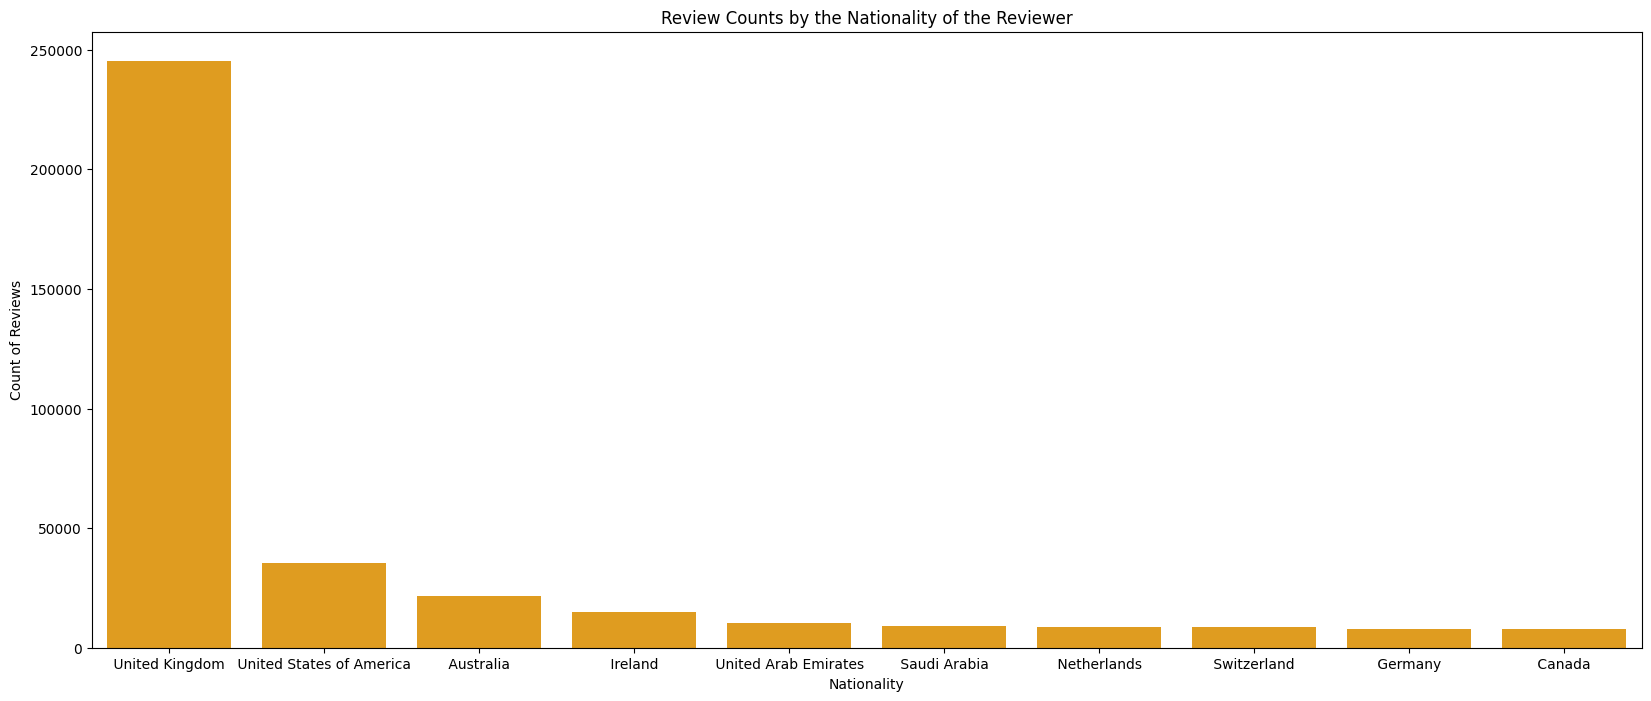

In [ ]:
nationality_scores_pd = nationality_scores.toPandas()

# Plot using Seaborn
plt.figure(figsize=(20, 8))
sns.barplot(x='Reviewer_Nationality', y='Count_of_reviews', data=nationality_scores_pd, color='orange')
plt.title('Review Counts by the Nationality of the Reviewer')
plt.xlabel('Nationality')
plt.ylabel('Count of Reviews')

# Show the bar plot
plt.show()

In [ ]:
# Create a temporary view
df.createOrReplaceTempView("df_view")

# Define the SQL query
query = """
SELECT
    CASE
        WHEN Tags LIKE '%Stayed 1 night%' THEN '1 night'
        WHEN Tags LIKE '%Stayed 2 nights%' THEN '2 nights'
        WHEN Tags LIKE '%Stayed 3 nights%' THEN '3 nights'
        WHEN Tags LIKE '%Stayed 4 nights%' THEN '4 nights'
        WHEN Tags LIKE '%Stayed 5 nights%' THEN '5 nights'
        WHEN Tags LIKE '%Stayed 6 nights%' THEN '6 nights'
        ELSE 'More than 6 nights'
    END as Length_of_Stay,
    COUNT(*) as Review_Count
FROM df_view
GROUP BY Length_of_Stay
ORDER BY Review_Count DESC
"""

# Execute the query
staying_scores = spark.sql(query)

# Show the result
staying_scores.show()

+------------------+------------+
|    Length_of_Stay|Review_Count|
+------------------+------------+
|           1 night|      193645|
|          2 nights|      133937|
|          3 nights|       95821|
|          4 nights|       47817|
|          5 nights|       20845|
|More than 6 nights|       13897|
|          6 nights|        9776|
+------------------+------------+



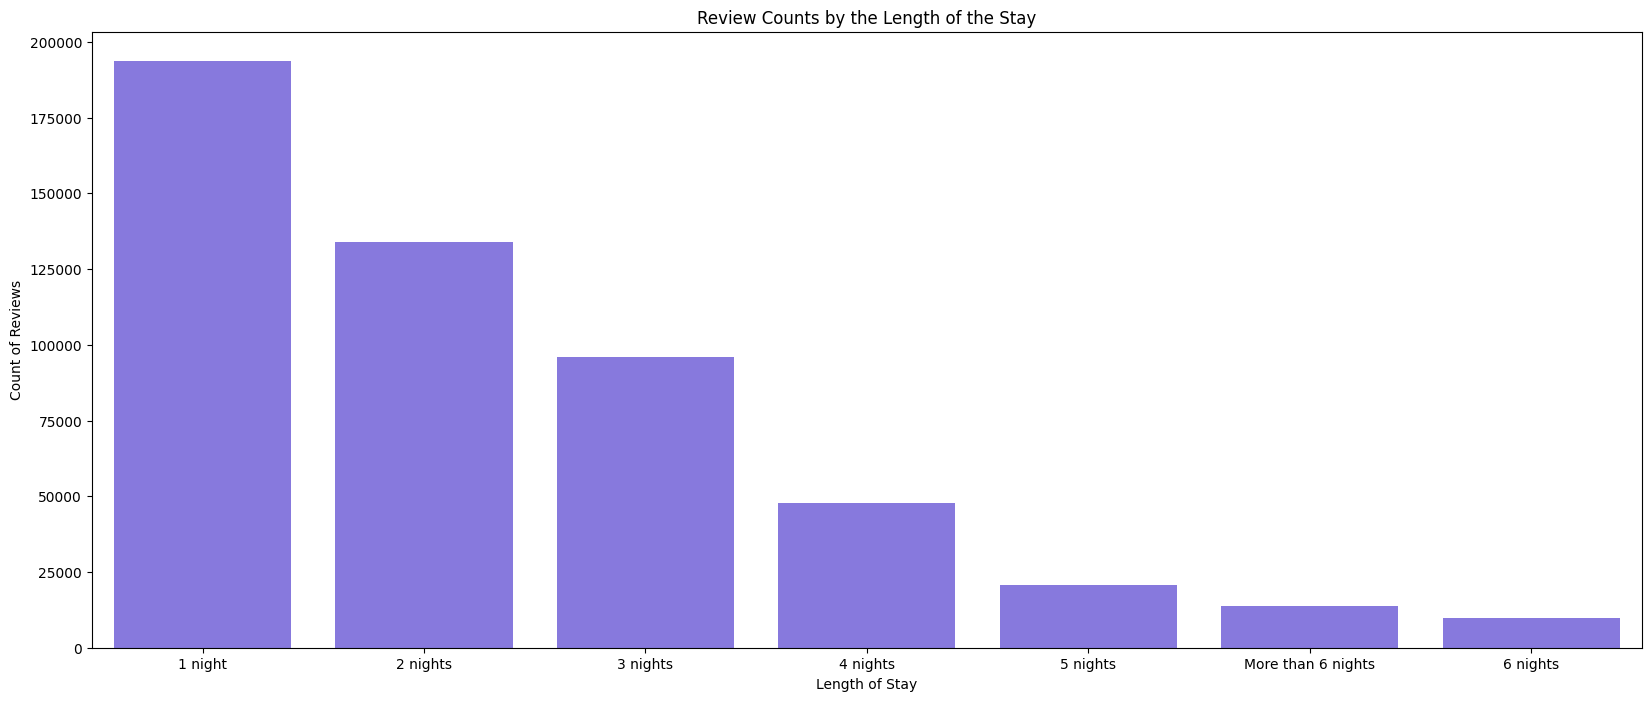

In [ ]:
# Convert Spark DataFrame to Pandas DataFrame
staying_scores_pd = staying_scores.toPandas()

# Plot using Seaborn
plt.figure(figsize=(20, 8))
sns.barplot(x='Length_of_Stay', y='Review_Count', data=staying_scores_pd, color='mediumslateblue')
plt.title('Review Counts by the Length of the Stay')
plt.xlabel('Length of Stay')
plt.ylabel('Count of Reviews')

# Show the bar plot
plt.show()

In [ ]:
df.createOrReplaceTempView("df_view")

# SQL query to categorize trip types and count reviews
query = """
SELECT
    CASE
        WHEN Tags LIKE '%Leisure trip%' THEN 'Leisure trip'
        WHEN Tags LIKE '%Business trip%' THEN 'Business trip'
        ELSE 'Other'
    END as Trip_Type,
    COUNT(*) as Review_Count
FROM df_view
GROUP BY Trip_Type
ORDER BY Review_Count DESC
"""

# Execute the query
trip_scores = spark.sql(query)

# Show the results
trip_scores.show()

+-------------+------------+
|    Trip_Type|Review_Count|
+-------------+------------+
| Leisure trip|      417778|
|Business trip|       82939|
|        Other|       15021|
+-------------+------------+



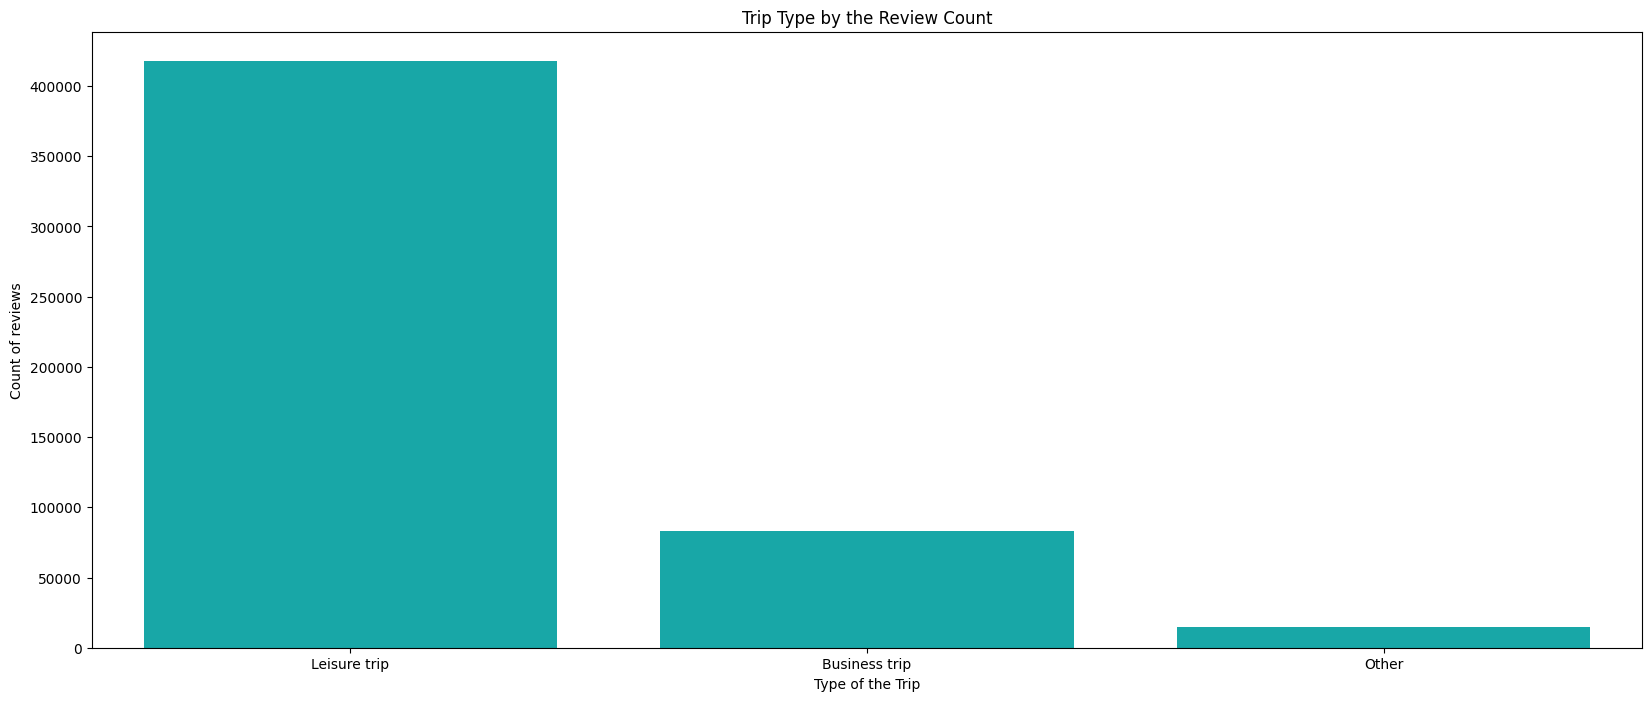

In [ ]:
trip_scores_pd = trip_scores.toPandas()

# Plot using Seaborn:

plt.figure(figsize=(20, 8))
sns.barplot(x='Trip_Type', y='Review_Count', data=trip_scores_pd, color = 'c')
plt.title('Trip Type by the Review Count')
plt.xlabel('Type of the Trip')
plt.ylabel('Count of reviews')

# Show the bar plot
plt.show()

#Natural Language Processing:

##Sentiment Analysis:

In [ ]:
# Spark DataFrame to Pandas DataFrame:

df1 = df.toPandas()

df1.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,...,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng,Review_Year,Review_Month,Review_Day,Review_DayOfWeek
0,s Gravesandestraat Oost AA Amsterdam Nether...,194,2017-08-03,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,...,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0,52.3605759,4.9159683,2017,8,3,5
1,s Gravesandestraat Oost AA Amsterdam Nether...,194,2017-08-03,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,...,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0,52.3605759,4.9159683,2017,8,3,5
2,s Gravesandestraat Oost AA Amsterdam Nether...,194,2017-07-31,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,...,9,7.1,"[' Leisure trip ', ' Family with young childre...",3,52.3605759,4.9159683,2017,7,31,2
3,s Gravesandestraat Oost AA Amsterdam Nether...,194,2017-07-31,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,...,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3,52.3605759,4.9159683,2017,7,31,2
4,s Gravesandestraat Oost AA Amsterdam Nether...,194,2017-07-24,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,...,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10,52.3605759,4.9159683,2017,7,24,2


In [ ]:
analyzer = SentimentIntensityAnalyzer()

# VADER function:

def get_vader_sentiment(text):

    vs = analyzer.polarity_scores(text)

    if vs['compound'] > 0:

        return 'positive'

    elif vs['compound'] == 0:

        return 'neutral'

    else:

        return 'negative'

# Applying the function below:

df1['Positive_Review_Sentiment_new'] = df1['Positive_Review'].apply(get_vader_sentiment)

df1['Negative_Review_Sentiment_new'] = df1['Negative_Review'].apply(get_vader_sentiment)

In [ ]:
df1.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,...,Tags,days_since_review,lat,lng,Review_Year,Review_Month,Review_Day,Review_DayOfWeek,Positive_Review_Sentiment_new,Negative_Review_Sentiment_new
0,s Gravesandestraat Oost AA Amsterdam Nether...,194,2017-08-03,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,...,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0,52.3605759,4.9159683,2017,8,3,5,positive,negative
1,s Gravesandestraat Oost AA Amsterdam Nether...,194,2017-08-03,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,...,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0,52.3605759,4.9159683,2017,8,3,5,positive,positive
2,s Gravesandestraat Oost AA Amsterdam Nether...,194,2017-07-31,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,...,"[' Leisure trip ', ' Family with young childre...",3,52.3605759,4.9159683,2017,7,31,2,positive,negative
3,s Gravesandestraat Oost AA Amsterdam Nether...,194,2017-07-31,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,...,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3,52.3605759,4.9159683,2017,7,31,2,positive,negative
4,s Gravesandestraat Oost AA Amsterdam Nether...,194,2017-07-24,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,...,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10,52.3605759,4.9159683,2017,7,24,2,positive,negative


In [ ]:
sentiment_distribution_positive = df1['Positive_Review_Sentiment_new'].value_counts()

sentiment_distribution_negative = df1['Negative_Review_Sentiment_new'].value_counts()

print(sentiment_distribution_positive)

print(sentiment_distribution_negative)

Positive_Review_Sentiment_new
positive    397656
neutral      75261
negative     42821
Name: count, dtype: int64
Negative_Review_Sentiment_new
positive    234693
negative    146209
neutral     134836
Name: count, dtype: int64


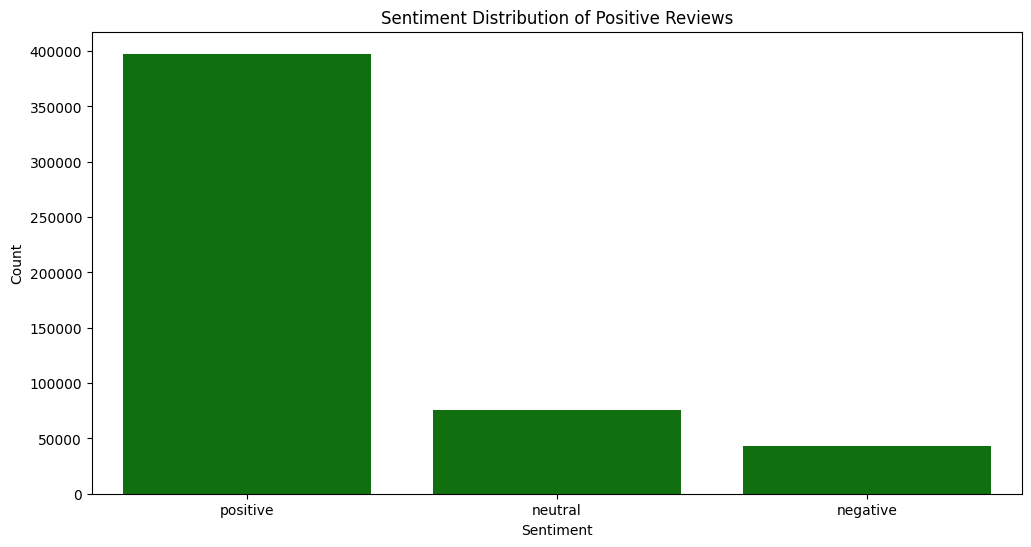

In [ ]:
# Visualization:

plt.figure(figsize=(12, 6))

sns.barplot(x=sentiment_distribution_positive.index, y=sentiment_distribution_positive.values, color = 'green')

plt.title('Sentiment Distribution of Positive Reviews')

plt.xlabel('Sentiment')

plt.ylabel('Count')

plt.show()

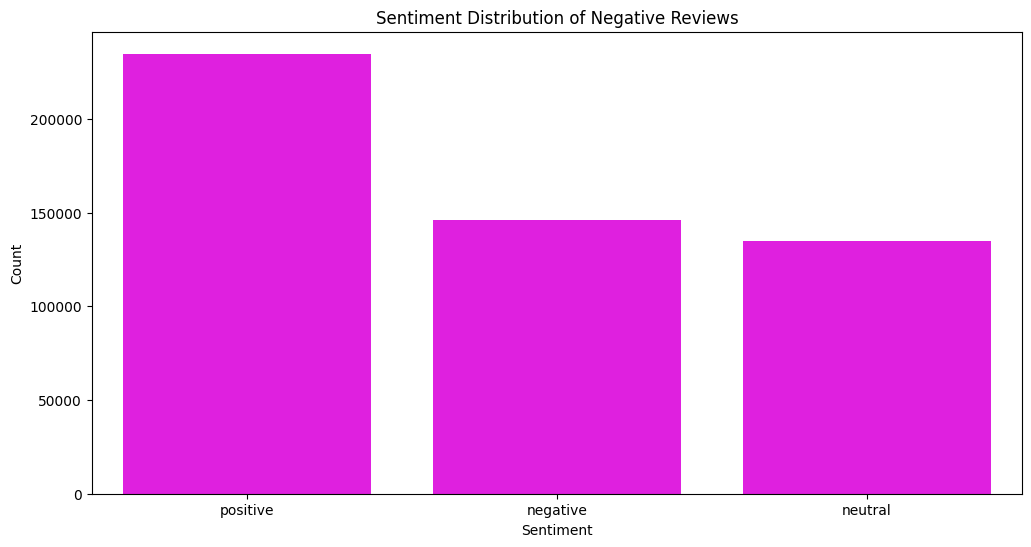

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x=sentiment_distribution_negative.index, y=sentiment_distribution_negative.values, color = 'magenta')
plt.title('Sentiment Distribution of Negative Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

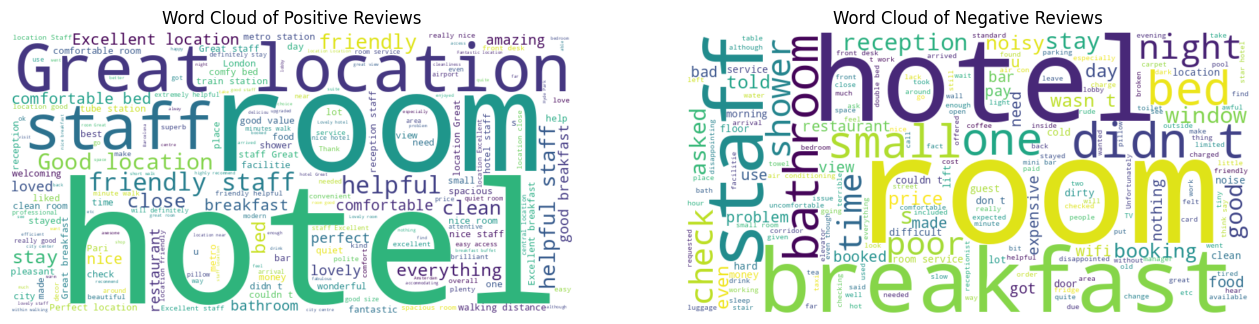

In [ ]:
positive_reviews_text = " ".join(review for review in df1[df1['Positive_Review_Sentiment_new'] == 'positive']['Positive_Review'])

negative_reviews_text = " ".join(review for review in df1[df1['Negative_Review_Sentiment_new'] == 'negative']['Negative_Review'])

# Wordclouds:

wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews_text)

wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews_text)

# Plot:

plt.figure(figsize=(16, 8))

# Word cloud for positive reviews:

plt.subplot(1, 2, 1)

plt.imshow(wordcloud_positive, interpolation='bilinear')

plt.title('Word Cloud of Positive Reviews')

plt.axis('off')

# Word cloud for negative reviews:

plt.subplot(1, 2, 2)

plt.imshow(wordcloud_negative, interpolation='bilinear')

plt.title('Word Cloud of Negative Reviews')

plt.axis('off')

plt.show()

In [ ]:
# Calculating Polarity and Subjectivity:

df1['Positive_Polarity'] = df1['Positive_Review'].apply(lambda x: TextBlob(x).sentiment.polarity)

df1['Positive_Subjectivity'] = df1['Positive_Review'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

df1['Negative_Polarity'] = df1['Negative_Review'].apply(lambda x: TextBlob(x).sentiment.polarity)

df1['Negative_Subjectivity'] = df1['Negative_Review'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [ ]:
print(df1['Positive_Polarity'])

print(df1['Positive_Subjectivity'])

print(df1['Negative_Polarity'])

print(df1['Negative_Subjectivity'])

0         0.283333
1         0.241960
2         0.460000
3         0.625000
4         0.300000
            ...   
515733    0.000000
515734    0.250000
515735   -0.113636
515736    0.300000
515737    0.780000
Name: Positive_Polarity, Length: 515738, dtype: float64
0         0.683333
1         0.475492
2         0.620000
3         0.875000
4         0.700000
            ...   
515733    0.000000
515734    0.500000
515735    0.545455
515736    0.733333
515737    1.000000
Name: Positive_Subjectivity, Length: 515738, dtype: float64
0         0.028671
1         0.150000
2         0.032653
3        -0.070370
4        -0.009091
            ...   
515733    0.000000
515734   -0.250000
515735    0.100000
515736    0.150000
515737    0.200000
Name: Negative_Polarity, Length: 515738, dtype: float64
0         0.434911
1         0.400000
2         0.539541
3         0.535802
4         0.543939
            ...   
515733    0.000000
515734    0.888889
515735    0.680000
515736    0.400000
515737    0

<ipython-input-40-f46f20967bd2>:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  sentiment_over_time = new_df.resample('M').agg({


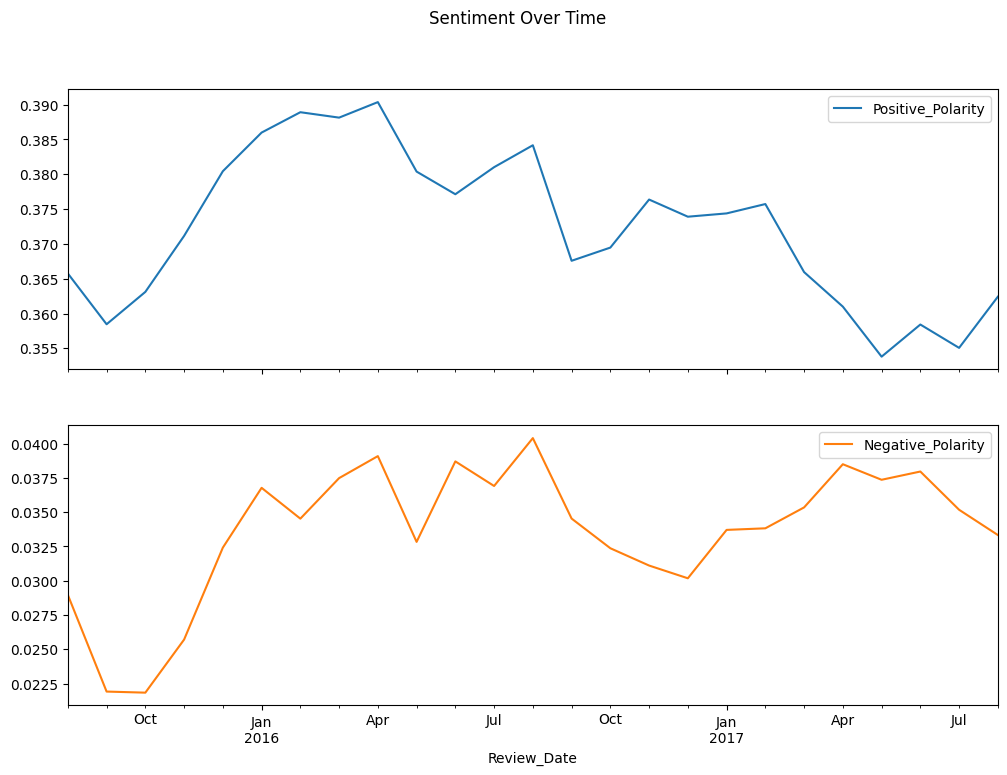

In [ ]:
# Finding Sentiment over time:

new_df = df1.copy()

new_df['Review_Date'] = pd.to_datetime(new_df['Review_Date'])

new_df.set_index('Review_Date', inplace=True)

sentiment_over_time = new_df.resample('M').agg({

    'Positive_Polarity': 'mean',

    'Negative_Polarity': 'mean'
})

sentiment_over_time.plot(subplots=True, figsize=(12, 8), title="Sentiment Over Time")

plt.show()

In [ ]:
# Top 10 hotels by sentiments:

hotel_sentiments = df1.groupby('Hotel_Name').agg({

    'Positive_Polarity': 'mean',

    'Negative_Polarity': 'mean'

}).sort_values(by='Positive_Polarity', ascending=False)

print(hotel_sentiments.head(10))

                                   Positive_Polarity  Negative_Polarity
Hotel_Name                                                             
InterContinental Amstel Amsterdam           0.543345           0.041808
Room Mate Gerard                            0.514076          -0.047344
Hotel The Serras                            0.513095           0.098673
Splendide Royal Paris                       0.506250           0.004129
Hotel Astra Opera Astotel                   0.501017           0.065995
Hotel Sans Souci Wien                       0.490530           0.092365
H tel D Aubusson                            0.484232           0.091615
H10 Casa Mimosa 4 Sup                       0.482646           0.102320
Hotel Landhaus Fuhrgassl Huber              0.480706           0.151665
Aparthotel Arai 4 Superior                  0.479678           0.099144


#Feature Engineering

In [ ]:
# Calculate Review Lengths:

df1['Positive_Review_Length'] = df1['Positive_Review'].apply(len)

df1['Negative_Review_Length'] = df1['Negative_Review'].apply(len)

In [ ]:
# Define functions for polarity and subjectivity:

def get_polarity(text):

    return TextBlob(text).sentiment.polarity

def get_subjectivity(text):

    return TextBlob(text).sentiment.subjectivity

# Apply sentiment analysis:

df1['Positive_Polarity'] = df1['Positive_Review'].apply(get_polarity)

df1['Negative_Polarity'] = df1['Negative_Review'].apply(get_polarity)

df1['Positive_Subjectivity'] = df1['Positive_Review'].apply(get_subjectivity)

df1['Negative_Subjectivity'] = df1['Negative_Review'].apply(get_subjectivity)

KeyboardInterrupt: 

In [ ]:
df1['Review_Date'] = pd.to_datetime(df1['Review_Date'])

df1['Days_Since_Review'] = (pd.Timestamp.now() - df1['Review_Date']).dt.days


In [ ]:
df1['Reviewer_Nationality_Index'] = pd.factorize(df1['Reviewer_Nationality'])[0]

df1['Tags_Index'] = pd.factorize(df1['Tags'])[0]

In [ ]:
# Define Churn:

threshold = 4.0

df1['Churn'] = (df1['Reviewer_Score'] < threshold).astype(int)

In [ ]:
# Select relevant features for the model:

feature_cols = [
    'Positive_Review_Length', 'Negative_Review_Length', 'Tags_Index',
    'Average_Score', 'Review_Total_Negative_Word_Counts', 'Review_Total_Positive_Word_Counts',
    'Total_Number_of_Reviews_Reviewer_Has_Given']

X = df1[feature_cols]

y = df1['Churn']

#Predictive Modeling:

In [ ]:
#Train Test Split:

from sklearn.ensemble import RandomForestClassifier

#Train Test Split:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

# Initialize Random Forest:

rf = RandomForestClassifier(n_estimators=50, random_state=12345)

# Train the model:

rf.fit(X_train, y_train)

# Make predictions:

y_pred = rf.predict(X_test)

# Evaluate the model:

rf_accuracy = accuracy_score(y_test, y_pred)

print("Random Forest Accuracy:", rf_accuracy)



Random Forest Accuracy: 0.9796602939465622


In [ ]:
print(df1['Churn'].value_counts(normalize=True))

Churn
0    0.979199
1    0.020801
Name: proportion, dtype: float64


#Class Imbalance:

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=123)

X_resampled, y_resampled = smote.fit_resample(X, y)

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

undersampler = RandomUnderSampler(random_state=123)

X_resampled, y_resampled = undersampler.fit_resample(X, y)


In [ ]:
from imblearn.under_sampling import RandomUnderSampler

undersampler = RandomUnderSampler(random_state=123)

X_resampled, y_resampled = undersampler.fit_resample(X, y)

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(y_test, y_pred))

print("ROC-AUC Score:", roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))


              precision    recall  f1-score   support

           0       0.98      1.00      0.99    101033
           1       0.52      0.09      0.16      2115

    accuracy                           0.98    103148
   macro avg       0.75      0.55      0.57    103148
weighted avg       0.97      0.98      0.97    103148

ROC-AUC Score: 0.8117253616477486


In [ ]:
rf = RandomForestClassifier(n_estimators=50, class_weight='balanced', random_state=123)

rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', n_estimators=50,
                       random_state=123)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report

# Resample data:

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=123)

X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train the model:

rf = RandomForestClassifier(n_estimators=50, random_state=123)

rf.fit(X_resampled, y_resampled)

# Evaluate on the original test set:

y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      0.97      0.98    101033
           1       0.17      0.33      0.22      2115

    accuracy                           0.95    103148
   macro avg       0.58      0.65      0.60    103148
weighted avg       0.97      0.95      0.96    103148



In [ ]:
# XGBoost to handle the class imbalance well:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from xgboost import XGBClassifier

# Calculate scale_pos_weight

num_neg = (y_train == 0).sum()

num_pos = (y_train == 1).sum()

scale_pos_weight = num_neg / num_pos

# Train XGBoost model

xgb = XGBClassifier(scale_pos_weight=scale_pos_weight, n_estimators=100, random_state=42)

xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

# Make predictions
y_pred = xgb.predict(X_test)

y_probs = xgb.predict_proba(X_test)[:, 1]

# Evaluate
print(classification_report(y_test, y_pred))

print("ROC-AUC Score:", roc_auc_score(y_test, y_probs))


              precision    recall  f1-score   support

           0       0.99      0.84      0.91    100983
           1       0.09      0.74      0.16      2165

    accuracy                           0.84    103148
   macro avg       0.54      0.79      0.54    103148
weighted avg       0.97      0.84      0.90    103148

ROC-AUC Score: 0.8760195362725288


In [ ]:
from sklearn.metrics import precision_recall_curve

y_probs = xgb.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Find the best threshold (e.g., maximize F1-score or balance precision and recall)

optimal_idx = (precision + recall).argmax()

optimal_threshold = thresholds[optimal_idx]

# Apply the new threshold

y_pred_adjusted = (y_probs >= optimal_threshold).astype(int)

print(classification_report(y_test, y_pred_adjusted))


              precision    recall  f1-score   support

           0       1.00      0.01      0.02    100983
           1       0.02      1.00      0.04      2165

    accuracy                           0.03    103148
   macro avg       0.51      0.50      0.03    103148
weighted avg       0.98      0.03      0.02    103148



In [ ]:
from sklearn.metrics import f1_score

# Calculate F1-score for each threshold
f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precision, recall)]
optimal_idx = f1_scores.index(max(f1_scores))
optimal_threshold = thresholds[optimal_idx]

# Apply the new threshold
y_pred_adjusted = (y_probs >= optimal_threshold).astype(int)
print(classification_report(y_test, y_pred_adjusted))


              precision    recall  f1-score   support

           0       0.99      0.98      0.98    100983
           1       0.27      0.32      0.29      2165

    accuracy                           0.97    103148
   macro avg       0.63      0.65      0.64    103148
weighted avg       0.97      0.97      0.97    103148

